
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_amarillo@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio A/B Testing Parametrico


#### Ejercicio 1:  Linea de montaje 

En una fabrica de componenetes textil se quiere comparar el tiempo de fabricacion de un determinado producto mediante tres métodos diferentes.  Se seleccionan aleatoriamente productos elaborados con cada uno de los métodos y se observa el tiempo de fabricación. 


1. ¿Se verifican los supuestos del modelo de análisis de la varianza?

2. ¿Existe evidencia de que el método influye en el tiempo medio de elaboración del producto?

3. La empresa valora que el tiempo de fabricación sea el menor posible. ¿Qué método cree que ofrece mejores resultados?

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_montaje = pd.read_csv('C:\\Users\\DELL\\Git\\AB_Testing\\labs\\datos\\linea_montaje.csv')

H0 = el metodo no influye en el tiempo medio de elaboración del producto
H1 = el metodo influye en el tiempo medio de elaboración del producto

# EDA

- Me doy cuenta que tengo dos columnas, una de metodo (A,B,C) y otra de los minutos que le toma en cada caso a ese método. Tengo una columna categórica y una numérica.
- En una primera observación, pude encontrar 2 datos negativos. Procedí a convertirlos a positivos para seguir formando parte con estos datos, y que representen parte de los datos al sumarlos como casos en los que se perdió tiempo pero igual forman parte de casos que pueden suceder.
- Los datos estaban distribuidos en 3 grupos iguales de 50, por lo que ya sabía que debía buscar su normalidad con Kolmogorov.
    - Al buscar su normalidad, todas las categorías siguen una distribución normal ya que su pvalue es mayor que 0.05.
- Con respecto a la homogeneidad, usé Levene porque luego de visualizar pude ver que los datos tienen cola en su representación. Estos datos pueden provenir de una distribución normal, no rechazamos la hipótesis nula
- Con relación a la ANOVA, tenemos un valor < 0.05, por lo que podemos rechazar la H0 y decir que hay una diferencia significativa entre las 3 muestras.
- Dejo un barplot con las medias de cada grupo para demostrar lo anterior

In [3]:
df_montaje.head()

,minutos,metodo
0,4.166484,A
1,4.887466,A
2,0.727608,A
3,8.280542,A
4,1.413129,A


In [4]:
df_montaje.dtypes

minutos    float64
metodo      object
dtype: object

In [5]:
df_montaje.describe() #max 12.05, min -0.81

,minutos
count,150.000000
mean,4.895103
std,2.222707
min,-0.818899
25%,3.528356
50%,4.870153
75%,6.328776
max,12.059491


In [6]:
df_montaje[df_montaje['minutos'] < 0]

,minutos,metodo
76,-0.818899,B
99,-0.187206,B


In [7]:
df_montaje['minutos'] =  df_montaje['minutos'].apply(lambda x: abs(x) if x < 0 else x)

In [8]:
df_montaje['metodo'].unique()

array(['A', 'B', 'C'], dtype=object)

In [9]:
df_montaje['metodo'].value_counts().reset_index()

,metodo,count
0,A,50
1,B,50
2,C,50


In [10]:
df_montaje.shape # al ser un contenido mayor a 30, tenemos que hacer el ruso

(150, 2)

Tenemos 150 datos, perfectamente distribuidos en 3 categorías

In [11]:
df_medias_std = df_montaje.groupby('metodo')['minutos'].agg(["mean", "std", 'median'])

In [26]:
df_medias_std.reset_index()

,metodo,mean,std,median
0,A,4.720512,2.102454,4.690071
1,B,4.404768,1.997027,4.506685
2,C,5.600274,2.329937,5.064969


In [29]:
print(df_medias_std['std'][0])

2.1024544034979136


In [30]:
distA = np.random.normal(loc=df_medias_std['mean'][0], scale=df_medias_std['std'][0], size=50)
distB = np.random.normal(loc=df_medias_std['mean'][1], scale=df_medias_std['std'][1], size=50)
distC = np.random.normal(loc=df_medias_std['mean'][2], scale=df_medias_std['std'][2], size=50) #loc es la media, #scale es la desv.std y size es el tamaño de la muestra

In [31]:
stats.kstest(df_montaje[df_montaje['metodo'] == 'A']['minutos'], distA) #datos normales

KstestResult(statistic=0.12, pvalue=0.8692618870414056, statistic_location=6.9999341980191545, statistic_sign=-1)

In [32]:
stats.kstest(df_montaje[df_montaje['metodo'] == 'B']['minutos'], distB) #datos normales

KstestResult(statistic=0.12, pvalue=0.8692618870414056, statistic_location=1.7309626669282705, statistic_sign=1)

In [33]:
stats.kstest(df_montaje[df_montaje['metodo'] == 'C']['minutos'], distC) #datos normales

KstestResult(statistic=0.22, pvalue=0.17858668181221732, statistic_location=5.1334868524408375, statistic_sign=1)

In [34]:
def calcular_levene(df,columna_grupos,columna_metrica): # lo mismo de abajo, pero de esta forma toma todos los valores
    unicos = df[columna_grupos].unique()
    for grupo in unicos:
        df_metrica = df[df[columna_grupos]== grupo][columna_metrica]
        globals()[grupo] = df_metrica
    print(stats.levene(*[globals()[var] for var in unicos]))
calcular_levene(df_montaje,"metodo","minutos") #homocedasticos

LeveneResult(statistic=0.6377981201955287, pvalue=0.5299107034782387)


Esto quiere decir que los datos son homogeneos, no rechazamos la hipótesis nula.

<Axes: xlabel='minutos', ylabel='Count'>

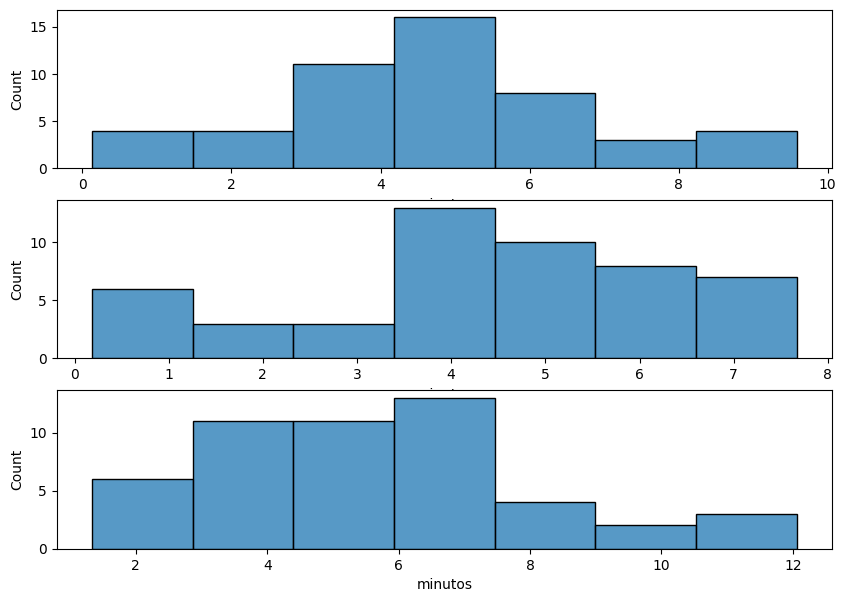

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (10,7))

axes = axes.flat # pasamos al 3x1

sns.histplot(x='minutos', data= df_montaje[df_montaje['metodo']=='A'], ax=axes[0])#vemos que tiene cola, por eso hacemos levene
sns.histplot(x='minutos', data= df_montaje[df_montaje['metodo']=='B'], ax=axes[1])#vemos que tiene cola, por eso hacemos levene
sns.histplot(x='minutos', data= df_montaje[df_montaje['metodo']=='C'], ax=axes[2])#vemos que tiene cola, por eso hacemos levene

In [104]:
def calcular_anova(df,columna_grupos,columna_metrica): #volvemos a utilizar la funcion, pero esta vez para calcular ANOVA porque son 3 grupos
    unicos = df[columna_grupos].unique()
    for grupo in unicos:
        df_metrica = df[df[columna_grupos]== grupo][columna_metrica]
        globals()[grupo] = df_metrica
    print(stats.f_oneway(*[globals()[var] for var in unicos]))
calcular_anova(df_montaje,"metodo","minutos") #calculo parametrico

F_onewayResult(statistic=4.160769025074968, pvalue=0.017470102171365402)


H0 las medias poblacionales son iguales.
Se rechaza el H0, porque el ANNOVA es menor que 0.05

<Axes: xlabel='metodo', ylabel='minutos'>

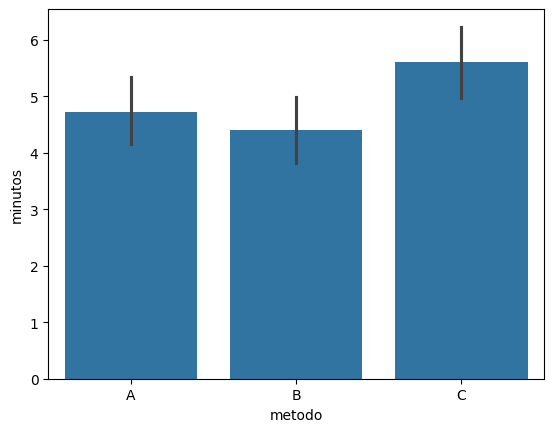

In [37]:
sns.barplot(x='metodo', y='minutos', data=df_montaje)

El método B es el mejor método a elegir tomando en cuenta el tiempo promedio de resolucion.
Tiempo promedio A = 4.72
Tiempo promedio B = 4.40
Tiempo promedio C = 5.60



#### Ejercicio 2: Densidad de Fluidos 


La convección es un mecanismo fundamental de transferencia de calor en fluidos, que ocurre debido a las variaciones en la densidad provocadas por diferencias de temperatura. Este fenómeno se manifiesta cuando las porciones del fluido que se calientan, al volverse menos densas, ascienden hacia regiones de menor temperatura, mientras que las porciones más frías, al ser más densas, descienden hacia las zonas donde la temperatura es más alta. Este movimiento continuo da lugar a las llamadas corrientes de convección, las cuales desempeñan un papel crucial en la distribución homogénea de la temperatura dentro del fluido, promoviendo un equilibrio térmico.

En este contexto, se ha diseñado y ejecutado un experimento con el propósito de investigar cómo se ve afectada la densidad de un fluido cuando se incrementa la temperatura en una región específica del sistema; por tanto se asegura la independencia y aleatoriedad del mismo. El objetivo del experimento es comprender en detalle las modificaciones en la densidad que resultan de este aumento térmico y cómo estas afectan el comportamiento global del fluido.


1. Analiza las suposiciones del modelo: ¿Se cumplen las condiciones de homocedasticidad, independencia y normalidad?
2. ¿Tiene la temperatura un impacto notable en la densidad del fluido?
3. ¿Es posible concluir que las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175?

H0: no se afecta la densidad de un fluido cuando se incrementa la temperatura
H1: afecta la densidad de un fluido cuando se incrementa la temperatura

# 1

Hay independencia de datos. Contamos con dos variables numéricas, temperatura y densidad, aunque la temperatura solo se toma en cuenta en relación a 4 valores. 
Tenemos 100 valores de densidad para cada temperatura., 400 en total.
Tenemos una media general de densidad de 21.73:
    - para 100 es de 21.72
    - para 125 es de 21.53
    - para 150 es de 21.76
    - para 175 es de 21.90
- Para calcular la normalidad, por el tamaño de la muestra tomamos a Kolmogorov. En todos, los casos tenemos un valor mayor a 0.05 por lo que existe una distribución normal entre los datos.
- Hice unas visualizaciones para comprender la distribución de los datos, donde puede darme cuenta de que existen colas por lo que la homogeneidad debía ser calculada con Levene.
- En este caso, no rechazamos la H0 y podemos decir que los datos tienen una distribución normal.


In [22]:
df_densidad = pd.read_csv('C:\\Users\\DELL\\Git\\AB_Testing\\labs\\datos\\densidad_fluidos.csv')

In [23]:
df_densidad.head()

,temperatura,densidad
0,100,21.790655
1,100,21.725900
2,100,21.806052
3,100,21.895319
4,100,21.716121


In [38]:
df_densidad.dtypes

temperatura      int64
densidad       float64
dtype: object

Tenemos solo datos numéricos, int y float

In [41]:
df_densidad['temperatura'].unique()

array([100, 125, 150, 175], dtype=int64)

Aunque son todas numéricas, tenemos 4 opciones de temperatura como muestro arriba.

In [39]:
df_densidad.describe()

,temperatura,densidad
count,400.000000,400.000000
mean,137.500000,21.733028
std,27.985854,0.169214
min,100.000000,21.323342
25%,118.750000,21.614630
50%,137.500000,21.742521
75%,156.250000,21.843457
max,175.000000,22.170432


La media de densidad es 21.73

In [51]:
df_densidad['temperatura'].value_counts().reset_index()

,temperatura,count
0,100,100
1,125,100
2,150,100
3,175,100


Los datos estan perfectamente distribuidos en cada temperatura

In [52]:
df_densidad.shape

(400, 2)

In [55]:
dfden_medias_std_median = df_densidad.groupby('temperatura')['densidad'].agg(["mean", "std", 'median']).reset_index()

In [56]:
dfden_medias_std_median

,temperatura,mean,std,median
0,100,21.729410,0.092615,21.727053
1,125,21.532402,0.102713,21.539059
2,150,21.766618,0.110576,21.769963
3,175,21.903682,0.113220,21.896423


In [70]:
dfden_medias_std_median['mean'][0].round(2)

21.73

Vamos a calcular la normalidad, tenemos que usar al ruso porque tenemos grupos de 100 unidades cada uno.

In [59]:
dist_den100 = np.random.normal(loc=dfden_medias_std_median['mean'][0], scale=dfden_medias_std_median['std'][0], size=100)
dist_den125 = np.random.normal(loc=dfden_medias_std_median['mean'][1], scale=dfden_medias_std_median['std'][1], size=100)
dist_den150 = np.random.normal(loc=dfden_medias_std_median['mean'][2], scale=dfden_medias_std_median['std'][2], size=100)
dist_den175 = np.random.normal(loc=dfden_medias_std_median['mean'][3], scale=dfden_medias_std_median['std'][3], size=100)

In [60]:
stats.kstest(df_densidad[df_densidad['temperatura'] == 100]['densidad'], dist_den100)

KstestResult(statistic=0.06, pvalue=0.9942356257694902, statistic_location=21.822723656860546, statistic_sign=-1)

In [62]:
stats.kstest(df_densidad[df_densidad['temperatura'] == 125]['densidad'], dist_den125)

KstestResult(statistic=0.1, pvalue=0.7020569828664881, statistic_location=21.44882013067675, statistic_sign=1)

In [63]:
stats.kstest(df_densidad[df_densidad['temperatura'] == 150]['densidad'], dist_den150)

KstestResult(statistic=0.09, pvalue=0.8154147124661313, statistic_location=21.875805427164924, statistic_sign=1)

In [64]:
stats.kstest(df_densidad[df_densidad['temperatura'] == 175]['densidad'], dist_den175)

KstestResult(statistic=0.08, pvalue=0.9084105017744525, statistic_location=21.893138833817225, statistic_sign=1)

<Axes: xlabel='densidad', ylabel='Count'>

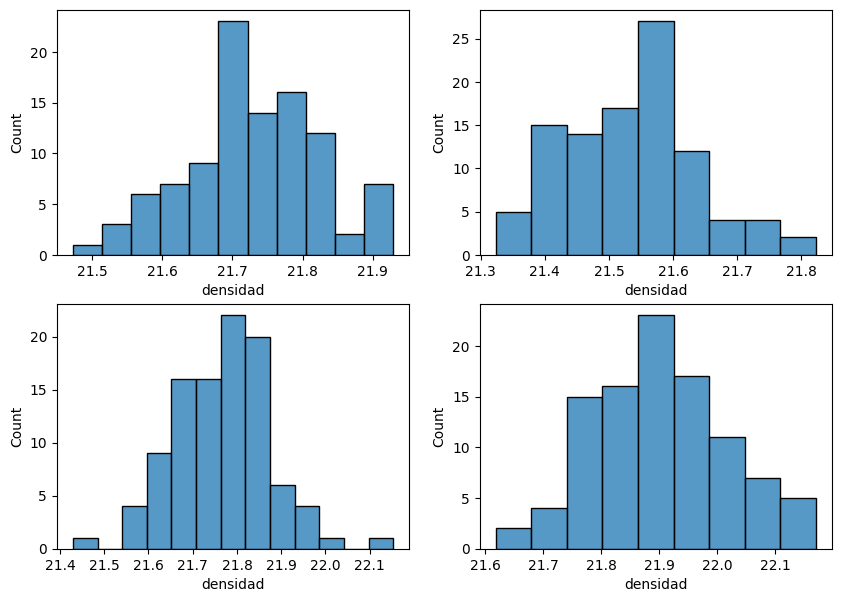

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10,7))

axes = axes.flat # pasamos al 3x1

sns.histplot(x='densidad', data= df_densidad[df_densidad['temperatura']==100], ax=axes[0])#vemos que tiene cola, por eso hacemos levene
sns.histplot(x='densidad', data= df_densidad[df_densidad['temperatura']==125], ax=axes[1])#vemos que tiene cola, por eso hacemos levene
sns.histplot(x='densidad', data= df_densidad[df_densidad['temperatura']==150], ax=axes[2])#vemos que tiene cola, por eso hacemos levene
sns.histplot(x='densidad', data= df_densidad[df_densidad['temperatura']==175], ax=axes[3])#vemos que tiene cola, por eso hacemos levene

Nuestra visualización nos presenta unas columnas que no tienen una normal perfecta, tienen colas.

- Usaremos LEVENE

In [68]:
def calcular_levene(df,columna_grupos,columna_metrica): # lo mismo de abajo, pero de esta forma toma todos los valores
    unicos = df[columna_grupos].unique()
    for grupo in unicos:
        df_metrica = df[df[columna_grupos]== grupo][columna_metrica]
        globals()[grupo] = df_metrica
    print(stats.levene(*[globals()[var] for var in unicos]))
calcular_levene(df_densidad,"temperatura","densidad") #homocedasticos

LeveneResult(statistic=1.3647908525254946, pvalue=0.25311302633232835)


Hay homogeneidad de varianza, homocedasticos, porque nuestro p-value con levene es > 0.05.

No hay evidencias estadísticas significativas en los grupos por temperatura. 

# 2. ¿Tiene la temperatura un impacto notable en la densidad del fluido?

In [66]:
def calcular_anova(df,columna_grupos,columna_metrica): #volvemos a utilizar la funcion, pero esta vez para calcular ANOVA porque son 3 grupos
    unicos = df[columna_grupos].unique()
    for grupo in unicos:
        df_metrica = df[df[columna_grupos]== grupo][columna_metrica]
        globals()[grupo] = df_metrica
    print(stats.f_oneway(*[globals()[var] for var in unicos]))
calcular_anova(df_densidad,"temperatura","densidad") #calculo parametrico

F_onewayResult(statistic=212.84277610615817, pvalue=3.327798065119595e-82)


Utilizando los datos de mi ANOVA, y viendo que el resultado es menor a 0.05 podemos decir que rechazamos la hipótesis nula y que se puede decir que hay evidencia significativa para decir que la densidad de un fluido se afecta cuando se incrementa la temperatura.

# 3. ¿Es posible concluir que las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175?

H0 = las temperaturan 100 y 125 no provocan menor densidad en el fluido comparadas con otra
H1: las temperaturas 100 y 125 provocan una menor densidad en el fluido comparadas con las otras

In [87]:
df_densidad_100_125 = df_densidad[(df_densidad['temperatura'] == 100) | (df_densidad['temperatura'] == 125)]
df_densidad_150_175 = df_densidad[(df_densidad['temperatura'] == 150) | (df_densidad['temperatura'] == 175)]

In [88]:
df_densidad_100_125.describe()

,temperatura,densidad
count,200.000000,200.000000
mean,112.500000,21.630906
std,12.531368,0.138807
min,100.000000,21.323342
25%,100.000000,21.537102
50%,112.500000,21.622429
75%,125.000000,21.736916
max,125.000000,21.928896


In [89]:
df_densidad_150_175.describe()

,temperatura,densidad
count,200.000000,200.000000
mean,162.500000,21.835150
std,12.531368,0.131073
min,150.000000,21.429454
25%,150.000000,21.752522
50%,162.500000,21.825754
75%,175.000000,21.920089
max,175.000000,22.170432


In [91]:
stats.ttest_ind(df_densidad_100_125['densidad'],df_densidad_150_175['densidad'])

TtestResult(statistic=-15.129677894969593, pvalue=3.563849634924047e-41, df=398.0)

Tomando en consideración este resultado, viendo que pvalue es < que 0.05, rechazamos la H0 de que los valores de 100 y 125 no provocan una menor densidad en el fluido. También se constata con el valor de la prueba, bastante alto.

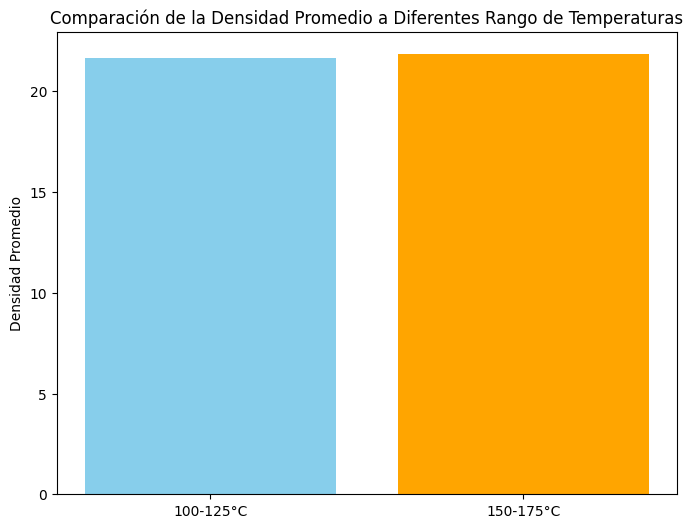

In [103]:
mean_100_125 = df_densidad_100_125['densidad'].mean()
mean_150_175 = df_densidad_150_175['densidad'].mean()

temperaturas = ['100-125°C', '150-175°C']
medias = [mean_100_125, mean_150_175]

plt.figure(figsize=(8, 6))
plt.bar(temperaturas, medias, color=['skyblue', 'orange'])
plt.ylabel('Densidad Promedio')
plt.title('Comparación de la Densidad Promedio a Diferentes Rango de Temperaturas')
plt.show()


Los datos son diferentes, aunque no lo parezca visualmente. Porque su t-student es pvalue=3.563849634924047e-41.

Las temperaturas de 100 y 125, en promedio, provocan una densidad significativamente diferente a las temperaturas de 150 y 175.